In [1]:
import numpy as np
import cvxpy as cp
from numpy import polynomial as P
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyqsp.completion import CompletionError
from pyqsp.angle_sequence import AngleFindingError

from mindquantum.core.gates import Measure, UnivMathGate
from mindquantum.core.circuit import Circuit
from mindquantum.simulator import Simulator

import time

In [162]:
def SpinChain(n,J,h):
    X = np.array([[0, 1], [1, 0]],dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]],dtype=complex)
    Z = np.array([[1, 0], [0, -1]],dtype=complex)
    def hopping(P,i):
        assert i < n, "i should be less than n"
        if i == 0 or i == n-1:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i or j == i+1:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    def potential(P,i):
        assert i < n, "i should be less than n"
        if i == 0:
            matrix = P
        else:
            matrix = np.eye(2,dtype=complex)
        for j in range(1,n):
            if j == i:
                matrix = np.kron(P,matrix)
            else:
                matrix = np.kron(np.eye(2,dtype=complex),matrix)
        return matrix
    
    # hopping term
    HoppingX = np.zeros((2**n,2**n),dtype=complex)
    HoppingY = np.zeros((2**n,2**n),dtype=complex)
    HoppingZ = np.zeros((2**n,2**n),dtype=complex)
    if n == 2:
        for i in range(n-1):
            HoppingX += hopping(X,i)*J[0]
            HoppingY += hopping(Y,i)*J[1]
            HoppingZ += hopping(Z,i)*J[2]
    else:
        for i in range(n):
            HoppingX += hopping(X,i)*J[0]
            HoppingY += hopping(Y,i)*J[1]
            HoppingZ += hopping(Z,i)*J[2]
    # potential term
    PotentialX = np.zeros((2**n,2**n),dtype=complex)
    PotentialY = np.zeros((2**n,2**n),dtype=complex)
    PotentialZ = np.zeros((2**n,2**n),dtype=complex)
    for i in range(n):
        PotentialX += potential(X,i)*h[0]
        PotentialY += potential(Y,i)*h[1]
        PotentialZ += potential(Z,i)*h[2]
    return HoppingX+HoppingY+HoppingZ+PotentialX+PotentialY+PotentialZ

def TimeEvolution(H,t):
    eigenv,U = np.linalg.eig(H)
    diag = np.diag(np.exp(-1.j*t*eigenv))
    return U@diag@np.linalg.inv(U)

def cheby_func(x, k):
    y = np.arccos(x)
    f = np.cos((2*k)*y)
    return f

def approx_poly(d, sigma_minus, sigma_plus, c = 0.999, eps = 0.001): 
    assert d%2 == 0 # d must be even
    M = 2*d + 1 # Number of grid points
    x = []
    for j in range(M):
        xj = -np.cos(j*np.pi/(M-1))
        if np.abs(xj)<= sigma_minus or np.abs(xj) >= sigma_plus:
            x.append(xj)
    
    def cost_func(x_c, coeff, c):
        A = []
        for k in range(int(coeff.shape[0])):
            A.append(cheby_func(x_c, k))
        A = np.array(A)
        A = A.transpose()
        
        b = [0 for _ in range(len(x_c))]
        for j, xj in enumerate(x_c):
            if np.abs(xj) <= sigma_minus:
                b[j] = 0
            else:
                b[j] = c
        b = np.array(b)
        return (A @ coeff) - b
    
    x_list = np.linspace(-1, 1, 101)   # Dense grid for constraints
    a = (sigma_minus+sigma_plus)/2
    h = sigma_minus-sigma_plus
    add_x_list = np.linspace(a-10*h, a+10*h, 21)
    
    coeff = cp.Variable(int(d/2))
    constraints = [np.sum([ck*cheby_func([xi], k)[0] for k,ck in enumerate(coeff)]) <= c for xi in x_list]
    constraints += [np.sum([ck*cheby_func([xi], k)[0] for k,ck in enumerate(coeff)]) >= eps for xi in x_list]
    constraints += [np.sum([ck*cheby_func([xi], k)[0] for k,ck in enumerate(coeff)]) <= c for xi in add_x_list]
    constraints += [np.sum([ck*cheby_func([xi], k)[0] for k,ck in enumerate(coeff)]) >= eps for xi in add_x_list]


    objective = cp.Minimize(cp.sum_squares(cost_func(x, coeff, c)))
    
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    coeffs = coeff.value
    
    return P.chebyshev.Chebyshev([coeffs[int(i/2)] if i%2==0 else 0 for i in range(2*len(coeffs)-1)])

# Quantum Signal Processing for phi values.
def phi_values(a, d, h, c=0.999, eps=0.001):
    assert d % 4 == 2  # guarantee that QETU circuit gives the function with the same sign with QSP circuit
    
    poly = approx_poly(d, a-h, a+h, c, eps)
    print("Polynomian approximation successful.")
    
    phizs    = QuantumSignalProcessingPhases(poly, signal_operator="Wx", method="laurent")
    phizs[0] = (phizs[-1] + phizs[0])/2
    phizs[-1] = phizs[0]
    
    phixs = [phiz + np.pi/4 if i==0 or i==len(phizs)-1 else phiz + np.pi/2 for i, phiz in enumerate(phizs)]
    return phixs, phizs, poly

def S(phi, dim):                     # phase gate in QETU
    H = np.array([[1, 1], [1, -1]])
    S_z = np.array([[np.exp(1j*phi), 0],[0, np.exp(-1j*phi)]])
    S_x =  0.5*(H @ S_z @ H)
    return np.kron(S_x, np.identity(dim))

def QETU(dU, phixs, error = 0.0):
    dim = len(dU)
    if error == 0.0:
        print("No error, using exact QETU.")
        dUs = [np.block([[np.eye(dim),np.eye(dim)*0.0],[np.eye(dim)*0.0, dU]]),
               np.block([[np.eye(dim),np.eye(dim)*0.0],[np.eye(dim)*0.0, np.conjugate(dU.T)]])]
        U = S(phixs[len(phixs)-1], dim)
        for i in range(1, len(phixs)):
            U = U @ dUs[i%2] @ S(phixs[len(phixs)-1-i], dim)
        return U
    else:
        U = S(phixs[len(phixs)-1], dim)
        for i in range(1, len(phixs)):
            randmat = np.random.randn(dim,dim)+1.j*np.random.randn(dim,dim)
            randmat = randmat*error
            if i % 2 == 0:
                cU = np.block([[np.eye(dim),np.eye(dim)*0.0],[np.eye(dim)*0.0, dU+randmat]])
                U = U @ cU @ S(phixs[len(phixs)-1-i], dim)
            else:
                cU = np.block([[np.eye(dim),np.eye(dim)*0.0],[np.eye(dim)*0.0, np.conjugate(dU.T)+randmat]])
                U = U @ cU @ S(phixs[len(phixs)-1-i], dim)
        return U

def success_prob(state, dU, a, d, max_iter_for_phis=15, reps=1, h = 0.001, c = 0.999, error = 0.0):
    i = 0
    n = int(np.log(state.shape[0])/np.log(2)) - 1
    
    while True:
        try:
            phixs, phizs, poly = phi_values(a, d, h, c=c)
            break
        except CompletionError:
            print("Completion Error encountered!")
            if i > max_iter_for_phis:
                raise Exception("Max Iteration for estimating the phis breached!")
            i = i + 1
            if d > 1000:
                c = c - 0.05
            elif d > 500:
                c = c - 0.02
            else:
                c = c - 0.01
            print(f"c updated to {c}!")
            if i > max_iter_for_phis / 2:
                print(f"QSP did not work for d = {d}, updating d to {d-4}")
                d = d - 4
        except AngleFindingError:
            print("AngleFindingError encountered!")
            if i>max_iter_for_phis:
                raise Exception("Max Iteration for estimating the phis breached!")
            i = i + 1
            
            if i > max_iter_for_phis / 2:
                print(f"QSP did not work for d = {d}, updating d to {d-4}")
                d = d - 4

    # Perform the Measurement
    start = time.time()
    QETU_mat = QETU(dU, phixs, error=error)
    cal_time = time.time() - start
    print("QETU matrix calculated in " + str(cal_time) + " seconds.")

    for i in range(reps):
        if reps > 1:
            print("\nLayer " + str(i))

        # estimate the success probability with quantum circuits sampling
        size = 1000
        sim = Simulator('mqvector',n+1)
        circ = Circuit()
        evol_gate = UnivMathGate('QETU',QETU_mat)
        circ += evol_gate.on([i for i in range(n+1)])
        circ += Measure('q0').on(n)
        
        sim.reset()
        sim.set_qs(state)
        result = sim.sampling(circuit=circ,shots=size)
        samples = result.data
        try:
            zero = samples['0']
        except:
            zero = 0
        try:
            one = samples['1']
        except:
            one = 0
        print("Prob 0: " + str(zero/size))
        print("Prob 1: " + str(one/size))
        success_prob = zero/size
        
    return success_prob, poly

def fuzzy_bisection(ground_state, l, r, dU, h=0.01, d=102, iter = 0, add_iter = 0, max_iter = 5, arg = None, tolerance = 0.001, fixed_circuit = None, error = 0.0):
    global polys
    if iter == 0:
        arg = [h,d]
    if fixed_circuit is not None:
        try:
            d = fixed_circuit["d"][iter]
            c = fixed_circuit["c"][iter]
            h = 1/d
        except:
            return ((r+l)/2)
    else:
        c = 0.999
    a_est = (r+l)/2
    print("------------------\nestimate_energy: " + str(a_est))
    print("iter: ", iter)
    print("additional iter: ", add_iter)
    print("d: ", d)
    print("h: ", h)
    print("left: ", l)
    print("right: ", r)
    
    if iter >= max_iter or (r-l)/2 < tolerance:
        return ((r+l)/2)
    
    # TODO: Determine d depending on the interval length.
    sp, poly = success_prob(ground_state, dU, a_est, d, h = h, c = c, error=error)
    polys.append(poly)
    
    standard = 0.7
    if fixed_circuit is not None:
        standard = 0.5

    if sp > standard:
        l = (r+l)/2
        d = int(4/(r-l))
        d += 2-(d % 4)
        return fuzzy_bisection(ground_state, l, r, dU, h = min((r-l)/4,arg[0]), d = max(d,arg[1]), iter = iter+1, add_iter=add_iter, arg = arg, fixed_circuit = fixed_circuit, error=error)
    elif sp < 1-standard:
        r = (r+l)/2
        d = int(4/(r-l))
        d += 2-(d % 4)
        return fuzzy_bisection(ground_state, l, r, dU,  h = min((r-l)/4,arg[0]), d = max(d,arg[1]), iter = iter+1, add_iter=add_iter, arg = arg, fixed_circuit = fixed_circuit, error=error)
    else:
        print("Not steep enough!")    
        d = d + 24
        h = 1/d
        
        if d > 2000:
            return ((r+l)/2)
        else:
            return fuzzy_bisection(ground_state, l, r, dU,  h = min(h,arg[0]), d = max(d,arg[1]), iter = iter, add_iter=add_iter+1, arg = arg, fixed_circuit = fixed_circuit, error=error)

In [ ]:
d = [102,102,102,102,274,274]
c = [0.99,0.99,0.99,0.99,0.96,0.97]
fixed_circuit = {"d": d, "c": c}

n = 8
J = [-1.0,-1.0,-1.5]
h = [1.5,0.0,0.5]
hamil = SpinChain(n,J,h)
ground_energy = np.linalg.eigvalsh(hamil)[0]

hamil = hamil*0.4 + np.identity(hamil.shape[0])*11
ground_state = 0.9*np.linalg.eig(hamil)[1][:,0]+np.sqrt(1-0.9**2)*np.linalg.eig(hamil)[1][:,1]
dU = TimeEvolution(hamil, 1.0)

l = 0.1
r = 0.6
state = np.kron(np.array([1,0],dtype=complex), ground_state)

In [ ]:
dU_error = [1e-2,1e-3,1e-4,1e-5,0]
samples = []
for i in tqdm(range(10),desc='samples',colour='blue'):
    energy_error = []
    for e in tqdm(dU_error,desc='error',colour='red'):
        polys = []
        estimate_coseig = fuzzy_bisection(state, l, r, dU,fixed_circuit=fixed_circuit, error=e)
        estimate_energy = (2*np.arccos(estimate_coseig)-11)/0.4
        print(f"Estimated energy {estimate_energy} with dU error {e}")
        energy_error.append(estimate_energy-ground_energy)
    print("Energy error: ", energy_error)
    samples.append(energy_error)

samples:   0%|          | 0/10 [00:00<?, ?it/s]

------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.7992148399353027 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.695188045501709 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 1.8964018821716309 seconds.
Prob 0: 1.0
Prob 1: 0.0
-----------------

QETU matrix calculated in 5.903590202331543 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.10933780670166 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0683975219726562 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
P

QETU matrix calculated in 6.125617504119873 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0237808227539062 seconds.
Prob 0: 0.921
Prob 1: 0.079
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.5718700885772705 seconds.
Prob 0: 0.007
Prob 1: 0.993
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.2914886474609375 seconds.
Prob 0: 0.008
Prob 1: 0.992
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4

QETU matrix calculated in 11.054376602172852 seconds.
Prob 0: 0.04
Prob 1: 0.96
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 4.066385269165039 seconds.
Prob 0: 0.903
Prob 1: 0.097
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 4.12282395362854 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 4.058682918548584 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125
Poly

QETU matrix calculated in 10.416788816452026 seconds.
Prob 0: 0.031
Prob 1: 0.969
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.752493381500244 seconds.
Prob 0: 0.906
Prob 1: 0.094
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.8200292587280273 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 3.8746750354766846 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.412

QETU matrix calculated in 10.211381673812866 seconds.
Prob 0: 0.025
Prob 1: 0.975
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 2.691561222076416 seconds.
Prob 0: 0.899
Prob 1: 0.101
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 3.0787198543548584 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 2.999385118484497 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter

samples:  10%|█         | 1/10 [06:36<59:31, 396.82s/it]

QETU matrix calculated in 8.581432342529297 seconds.
Prob 0: 0.023
Prob 1: 0.977
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.623443841934204 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.924522638320923 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 4.250411748886108 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------


QETU matrix calculated in 10.147061347961426 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.933817148208618 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.715742588043213 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!


QETU matrix calculated in 6.358790159225464 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.098827838897705 seconds.
Prob 0: 0.938
Prob 1: 0.062
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.8586301803588867 seconds.
Prob 0: 0.006
Prob 1: 0.994
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.525918960571289 seconds.
Prob 0: 0.009
Prob 1: 0.991
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.412

QETU matrix calculated in 5.619808673858643 seconds.
Prob 0: 0.05
Prob 1: 0.95
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2839362621307373 seconds.
Prob 0: 0.916
Prob 1: 0.084
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.291787624359131 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.269864559173584 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 7.710551023483276 seconds.
Prob 0: 0.028
Prob 1: 0.972
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9519035816192627 seconds.
Prob 0: 0.903
Prob 1: 0.097
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1252031326293945 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.296377420425415 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 5.789772987365723 seconds.
Prob 0: 0.024
Prob 1: 0.976
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.9972994327545166 seconds.
Prob 0: 0.896
Prob 1: 0.104
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.7254669666290283 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.9985918998718262 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
ite

samples:  20%|██        | 2/10 [12:48<50:57, 382.14s/it]

QETU matrix calculated in 4.6316375732421875 seconds.
Prob 0: 0.028
Prob 1: 0.972
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.8055155277252197 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9471025466918945 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 2.3002984523773193 seconds.
Prob 0: 1.0
Prob 1: 0.0
----------------

QETU matrix calculated in 5.48918342590332 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.3275771141052246 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.435946226119995 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
P

QETU matrix calculated in 5.916620969772339 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.8710501194000244 seconds.
Prob 0: 0.93
Prob 1: 0.07
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.3991079330444336 seconds.
Prob 0: 0.008
Prob 1: 0.992
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.087752103805542 seconds.
Prob 0: 0.009
Prob 1: 0.991
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 9.008056402206421 seconds.
Prob 0: 0.058
Prob 1: 0.942
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 3.7965519428253174 seconds.
Prob 0: 0.905
Prob 1: 0.095
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2945446968078613 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.132205009460449 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4

QETU matrix calculated in 6.743399620056152 seconds.
Prob 0: 0.022
Prob 1: 0.978
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2557153701782227 seconds.
Prob 0: 0.904
Prob 1: 0.096
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1474835872650146 seconds.
Prob 0: 0.002
Prob 1: 0.998
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.025557518005371 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.

QETU matrix calculated in 5.838793754577637 seconds.
Prob 0: 0.029
Prob 1: 0.971
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6434431076049805 seconds.
Prob 0: 0.899
Prob 1: 0.101
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6486303806304932 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6425199508666992 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
ite

samples:  30%|███       | 3/10 [17:58<40:44, 349.22s/it]

QETU matrix calculated in 4.9454662799835205 seconds.
Prob 0: 0.022
Prob 1: 0.978
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.312699317932129 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.6094939708709717 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 2.0478036403656006 seconds.
Prob 0: 1.0
Prob 1: 0.0
-----------------

QETU matrix calculated in 5.569985628128052 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9752748012542725 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0690207481384277 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!

QETU matrix calculated in 7.211587429046631 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.753889799118042 seconds.
Prob 0: 0.934
Prob 1: 0.066
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1309456825256348 seconds.
Prob 0: 0.012
Prob 1: 0.988
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.0728557109832764 seconds.
Prob 0: 0.016
Prob 1: 0.984
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.41

QETU matrix calculated in 5.824965953826904 seconds.
Prob 0: 0.064
Prob 1: 0.936
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.10074520111084 seconds.
Prob 0: 0.888
Prob 1: 0.112
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.6499361991882324 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.8620598316192627 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.41

QETU matrix calculated in 5.471175193786621 seconds.
Prob 0: 0.026
Prob 1: 0.974
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.97525954246521 seconds.
Prob 0: 0.898
Prob 1: 0.102
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.7138268947601318 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.000784158706665 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.41

QETU matrix calculated in 5.58930778503418 seconds.
Prob 0: 0.024
Prob 1: 0.976
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.539423942565918 seconds.
Prob 0: 0.901
Prob 1: 0.099
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.5508191585540771 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.5975971221923828 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
i

samples:  40%|████      | 4/10 [22:59<33:00, 330.05s/it]

QETU matrix calculated in 4.440111875534058 seconds.
Prob 0: 0.02
Prob 1: 0.98
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9829227924346924 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9681859016418457 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 2.0474517345428467 seconds.
Prob 0: 1.0
Prob 1: 0.0
----------------

QETU matrix calculated in 5.476699590682983 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.004503011703491 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9952106475830078 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!


QETU matrix calculated in 5.844393253326416 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.067671060562134 seconds.
Prob 0: 0.948
Prob 1: 0.052
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9342637062072754 seconds.
Prob 0: 0.008
Prob 1: 0.992
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 1.9459080696105957 seconds.
Prob 0: 0.01
Prob 1: 0.99
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 6.815519094467163 seconds.
Prob 0: 0.061
Prob 1: 0.939
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1333272457122803 seconds.
Prob 0: 0.905
Prob 1: 0.095
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1059372425079346 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.5158772468566895 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.

QETU matrix calculated in 7.421398878097534 seconds.
Prob 0: 0.023
Prob 1: 0.977
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2736542224884033 seconds.
Prob 0: 0.915
Prob 1: 0.085
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.588836431503296 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 1.9513108730316162 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.

QETU matrix calculated in 6.806278228759766 seconds.
Prob 0: 0.023
Prob 1: 0.977
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.4040436744689941 seconds.
Prob 0: 0.903
Prob 1: 0.097
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6633789539337158 seconds.
Prob 0: 0.004
Prob 1: 0.996
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.5044071674346924 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125

samples:  50%|█████     | 5/10 [28:02<26:42, 320.46s/it]

QETU matrix calculated in 5.658965826034546 seconds.
Prob 0: 0.029
Prob 1: 0.971
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.098710536956787 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.6620638370513916 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 1.954679012298584 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------

QETU matrix calculated in 5.686993598937988 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9264626502990723 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.042401075363159 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!


QETU matrix calculated in 5.6642913818359375 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9861626625061035 seconds.
Prob 0: 0.935
Prob 1: 0.065
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.166835308074951 seconds.
Prob 0: 0.004
Prob 1: 0.996
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.329195261001587 seconds.
Prob 0: 0.01
Prob 1: 0.99
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 5.8501527309417725 seconds.
Prob 0: 0.048
Prob 1: 0.952
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.00968337059021 seconds.
Prob 0: 0.901
Prob 1: 0.099
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.100921869277954 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.0102856159210205 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.41

QETU matrix calculated in 5.720402240753174 seconds.
Prob 0: 0.02
Prob 1: 0.98
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.679351568222046 seconds.
Prob 0: 0.91
Prob 1: 0.09
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.140383005142212 seconds.
Prob 0: 0.002
Prob 1: 0.998
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.288677453994751 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125
P

QETU matrix calculated in 5.773679256439209 seconds.
Prob 0: 0.034
Prob 1: 0.966
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6978168487548828 seconds.
Prob 0: 0.914
Prob 1: 0.086
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.7511987686157227 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6064205169677734 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125

samples:  60%|██████    | 6/10 [33:02<20:53, 313.35s/it]

QETU matrix calculated in 4.987588882446289 seconds.
Prob 0: 0.018
Prob 1: 0.982
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0688703060150146 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0529825687408447 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 2.0848138332366943 seconds.
Prob 0: 1.0
Prob 1: 0.0
----------------

QETU matrix calculated in 5.518472194671631 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0890145301818848 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0919854640960693 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!

QETU matrix calculated in 6.2939980030059814 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.24458646774292 seconds.
Prob 0: 0.951
Prob 1: 0.049
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.3364500999450684 seconds.
Prob 0: 0.01
Prob 1: 0.99
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.540989398956299 seconds.
Prob 0: 0.006
Prob 1: 0.994
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125


QETU matrix calculated in 5.938694953918457 seconds.
Prob 0: 0.055
Prob 1: 0.945
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1414272785186768 seconds.
Prob 0: 0.899
Prob 1: 0.101
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0766119956970215 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.0518407821655273 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 5.798474550247192 seconds.
Prob 0: 0.021
Prob 1: 0.979
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2375035285949707 seconds.
Prob 0: 0.905
Prob 1: 0.095
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1100223064422607 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.0912511348724365 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0

QETU matrix calculated in 6.536287307739258 seconds.
Prob 0: 0.021
Prob 1: 0.979
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.8304333686828613 seconds.
Prob 0: 0.917
Prob 1: 0.083
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.654066562652588 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6647717952728271 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter

samples:  70%|███████   | 7/10 [38:05<15:29, 309.90s/it]

QETU matrix calculated in 4.764212608337402 seconds.
Prob 0: 0.023
Prob 1: 0.977
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9989171028137207 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9706761837005615 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 2.4541358947753906 seconds.
Prob 0: 1.0
Prob 1: 0.0
----------------

QETU matrix calculated in 7.0061194896698 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0310468673706055 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0321927070617676 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
P

QETU matrix calculated in 5.921805143356323 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2685205936431885 seconds.
Prob 0: 0.917
Prob 1: 0.083
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.7000832557678223 seconds.
Prob 0: 0.015
Prob 1: 0.985
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.718993902206421 seconds.
Prob 0: 0.011
Prob 1: 0.989
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.41

QETU matrix calculated in 6.163114547729492 seconds.
Prob 0: 0.05
Prob 1: 0.95
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0381548404693604 seconds.
Prob 0: 0.896
Prob 1: 0.104
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.962360143661499 seconds.
Prob 0: 0.003
Prob 1: 0.997
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.0969951152801514 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.412

QETU matrix calculated in 5.322433710098267 seconds.
Prob 0: 0.027
Prob 1: 0.973
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9521052837371826 seconds.
Prob 0: 0.907
Prob 1: 0.093
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9423906803131104 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.0399415493011475 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.412

QETU matrix calculated in 5.954364061355591 seconds.
Prob 0: 0.029
Prob 1: 0.971
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.5740714073181152 seconds.
Prob 0: 0.915
Prob 1: 0.085
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.4276037216186523 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.4014818668365479 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
ite

samples:  80%|████████  | 8/10 [43:07<10:15, 307.58s/it]

QETU matrix calculated in 4.231440305709839 seconds.
Prob 0: 0.024
Prob 1: 0.976
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.35878849029541 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1572988033294678 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 1.9183905124664307 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------

QETU matrix calculated in 5.742940187454224 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0619399547576904 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9435584545135498 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!

QETU matrix calculated in 6.452318906784058 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.277179718017578 seconds.
Prob 0: 0.926
Prob 1: 0.074
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.4404609203338623 seconds.
Prob 0: 0.015
Prob 1: 0.985
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.3941283226013184 seconds.
Prob 0: 0.013
Prob 1: 0.987
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.41

QETU matrix calculated in 5.953731536865234 seconds.
Prob 0: 0.069
Prob 1: 0.931
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2378509044647217 seconds.
Prob 0: 0.919
Prob 1: 0.081
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1230385303497314 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 1.9821140766143799 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 6.037204742431641 seconds.
Prob 0: 0.027
Prob 1: 0.973
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.222912549972534 seconds.
Prob 0: 0.898
Prob 1: 0.102
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.3307011127471924 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.2848386764526367 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 6.112290620803833 seconds.
Prob 0: 0.031
Prob 1: 0.969
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.7462732791900635 seconds.
Prob 0: 0.894
Prob 1: 0.106
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6288111209869385 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.974290370941162 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter

samples:  90%|█████████ | 9/10 [48:14<05:07, 307.33s/it]

QETU matrix calculated in 5.048656463623047 seconds.
Prob 0: 0.021
Prob 1: 0.979
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0802536010742188 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.0925326347351074 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!
Polynomian approximation successful.
QETU matrix calculated in 1.7549617290496826 seconds.
Prob 0: 1.0
Prob 1: 0.0
----------------

QETU matrix calculated in 6.037593841552734 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.1
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.4701015949249268 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.148084878921509 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.5375
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.475
right:  0.6
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.98!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.97!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.96!


QETU matrix calculated in 6.23050594329834 seconds.
Prob 0: 1.0
Prob 1: 0.0
Estimated energy -22.839154291791804 with dU error 0.01
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.1298575401306152 seconds.
Prob 0: 0.935
Prob 1: 0.065
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.271580934524536 seconds.
Prob 0: 0.009
Prob 1: 0.991
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.36095929145813 seconds.
Prob 0: 0.011
Prob 1: 0.989
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125


QETU matrix calculated in 5.595237731933594 seconds.
Prob 0: 0.053
Prob 1: 0.947
Estimated energy -21.538540934993854 with dU error 0.001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 1.9189982414245605 seconds.
Prob 0: 0.894
Prob 1: 0.106
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.106884479522705 seconds.
Prob 0: 0.002
Prob 1: 0.998
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 1.9531280994415283 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4

QETU matrix calculated in 6.319021463394165 seconds.
Prob 0: 0.021
Prob 1: 0.979
Estimated energy -21.538540934993854 with dU error 0.0001
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.269218921661377 seconds.
Prob 0: 0.905
Prob 1: 0.095
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
QETU matrix calculated in 2.2700750827789307 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
QETU matrix calculated in 2.1750283241271973 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
iter:  3
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.4125

QETU matrix calculated in 5.906216382980347 seconds.
Prob 0: 0.026
Prob 1: 0.974
Estimated energy -21.538540934993854 with dU error 1e-05
------------------
estimate_energy: 0.35
iter:  0
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.1
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.6677839756011963 seconds.
Prob 0: 0.905
Prob 1: 0.095
------------------
estimate_energy: 0.475
iter:  1
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.6
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.7319107055664062 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.4125
iter:  2
additional iter:  0
d:  102
h:  0.00980392156862745
left:  0.35
right:  0.475
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 1.5913045406341553 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.38125
ite

samples: 100%|██████████| 10/10 [53:17<00:00, 319.79s/it]

QETU matrix calculated in 4.778095960617065 seconds.
Prob 0: 0.023
Prob 1: 0.977
Estimated energy -21.538540934993854 with dU error 0
Energy error:  [-1.2980204858193183, -1.2980204858193183, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675, 0.0025928709786313675]


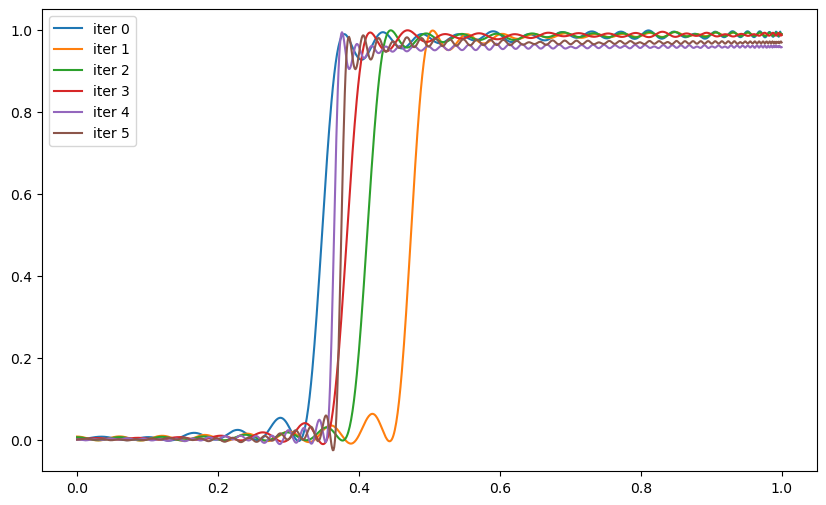

In [5]:
plt.figure(figsize=(10, 6))
cnt = 0
for poly in polys:
    x = np.linspace(0, 1, 1001)
    y = poly(x)
    plt.plot(x, y, label=f"iter {cnt}")
    cnt += 1
plt.legend()
plt.savefig("polynomial_approximation.png")

In [8]:
post_samples = np.array(np.abs(samples)).T
benchmark = []
for i in range(len(dU_error)):
    benchmark.append((np.mean(post_samples[i]),np.std(post_samples[i])))
print(benchmark)

[(1.2980204858193183, 0.0), (1.2980204858193183, 0.0), (0.0025928709786313675, 0.0), (0.0025928709786313675, 0.0), (0.0025928709786313675, 0.0), (0.0025928709786313675, 0.0)]


In [9]:
benchmark = np.array(benchmark)
print('mean:',benchmark[:,0])
print('std:',benchmark[:,1])

mean: [1.29802049 1.29802049 0.00259287 0.00259287 0.00259287 0.00259287]
std: [0. 0. 0. 0. 0. 0.]


# 2. Non-Hermitian

In [140]:
def GainLoss_Hamiltonian(g,delta=1.0,kappa=0.5):
    return np.array([[delta-1.j*g, kappa], [kappa, delta+1.j*g]])

def EP_time_evolution(t):
    U = np.array([[-1.j,2.0],[1.0,0.0]])
    Jordan_t = np.array([[np.exp(-1.j*t), -1.j*np.exp(-1.j*t)*t],[0.0, np.exp(-1.j*t)]])
    return U @ Jordan_t @ np.linalg.inv(U)

In [135]:
# before EP
l = 0.35
r = 0.75
delta_t = 3.2
gg = [0.2,0.3,0.4]
error = []
for g in gg:
    NHH = GainLoss_Hamiltonian(g)
    dU = TimeEvolution(NHH,delta_t)
    gs = np.sqrt(1-0.9**2)*np.linalg.eig(NHH)[1][:,0] + 0.9*np.linalg.eig(NHH)[1][:,1]
    gs = gs/np.linalg.norm(gs)
    gs_e = np.linalg.eig(NHH)[0][1]
    print(gs_e)

    state = np.kron(np.array([1,0],dtype=complex), gs)

    polys = []
    estimate_coseig = fuzzy_bisection(state, l, r, dU, error=0.0)
    print(2*np.arccos(estimate_coseig)/3.2)
    error.append(2*np.arccos(estimate_coseig)/3.2-gs_e)
error

(0.541742430504416-5.4905503128247676e-17j)
------------------
estimate_energy: 0.55
iter:  0
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.0020072460174560547 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.65
iter:  1
additional iter:  0
d:  102
h:  0.01
left:  0.55
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.979!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.003000497817993164 seconds.
Prob 0: 0.33
Prob 1: 0.67
Not steep enough!
------------------
estimate_energy: 0.65
iter:  1
additional iter:  1
d:  126
h:  0.007936507936507936
left:  0.55
right:  0.75
Polynomian approximation success

[(-0.02045560156363302+5.4905503128247676e-17j),
 (-0.0528222622886696+4.85722573273506e-17j),
 (-0.2395023296965847-9.71445146547012e-17j)]

In [136]:
np.abs(error)

array([0.0204556 , 0.05282226, 0.23950233])

In [138]:
# after EP
l = 0.35
r = 0.75
delta_t = 2.0
gg = [0.6,0.7,0.8]
error = []
for g in gg:
    NHH = GainLoss_Hamiltonian(g)
    dU = TimeEvolution(NHH,delta_t)
    gs = np.sqrt(1-0.9**2)*np.linalg.eig(NHH)[1][:,0] + 0.9*np.linalg.eig(NHH)[1][:,1]
    gs = gs/np.linalg.norm(gs)
    gs_e = np.linalg.eig(NHH)[0][1]
    print(gs_e)

    state = np.kron(np.array([1,0],dtype=complex), gs)

    polys = []
    estimate_coseig = fuzzy_bisection(state, l, r, dU, error=0.0)
    print(2*np.arccos(estimate_coseig)/2.0)
    error.append(2*np.arccos(estimate_coseig)/2.0-np.real(gs_e))
error

(1+0.3316624790355398j)
------------------
estimate_energy: 0.55
iter:  0
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.0019915103912353516 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.65
iter:  1
additional iter:  0
d:  102
h:  0.01
left:  0.55
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.979!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.002009868621826172 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.7
iter:  2
additional iter:  0
d:  102
h:  0.01
left:  0.65
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Po

[-0.27255376662305597, -0.27255376662305597, -0.27255376662305597]

In [139]:
np.abs(error)

array([0.27255377, 0.27255377, 0.27255377])

In [142]:
# EP
l = 0.35
r = 0.75
delta_t = 2.0
dU = EP_time_evolution(delta_t)
gs1 = np.array([-1.j,1.0])/np.sqrt(2)
gs2 = np.array([1.0,0.0])
gs = 0.9*gs1 + np.sqrt(1-0.9**2)*gs2
gs = gs/np.linalg.norm(gs)

state = np.kron(np.array([1,0],dtype=complex), gs)

polys = []
estimate_coseig = fuzzy_bisection(state, l, r, dU, error=0.0)
print(2*np.arccos(estimate_coseig)/2.0)
error = 2*np.arccos(estimate_coseig)/2.0 - 1.0

------------------
estimate_energy: 0.55
iter:  0
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.0023424625396728516 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.65
iter:  1
additional iter:  0
d:  102
h:  0.01
left:  0.55
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.979!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.001986265182495117 seconds.
Prob 0: 1.0
Prob 1: 0.0
------------------
estimate_energy: 0.7
iter:  2
additional iter:  0
d:  102
h:  0.01
left:  0.65
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation s

In [143]:
error

-0.27255376662305597

# 3. Floquet

In [163]:
 # non-T
l = 0.35
r = 0.75
dU = np.array([[-0.599986 - 0.7382 *1.j, 0, -0.0527668 + 0.303797 *1.j, 0], 
               [0, -0.814197 - 0.338483 *1.j, 0, -0.0807238 + 0.464755 *1.j], 
               [-0.215087 + 0.22094 *1.j, 0, -0.949803 - 0.0528952 *1.j, 0], 
               [0, -0.329044 + 0.337998 *1.j, 0, -0.751733 - 0.460852 *1.j]])
# dU = np.linalg.matrix_power(dU, 2)
gs = np.array([-0.612372, -0.353553, 0.353553, 0.612372])

state = np.kron(np.array([1,0],dtype=complex), gs)

polys = []
estimate_coseig = fuzzy_bisection(state, l, r, dU, error=0.0)
print(2*np.arccos(estimate_coseig)/2.0)

------------------
estimate_energy: 0.55
iter:  0
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.0020096302032470703 seconds.
Prob 0: 0.0
Prob 1: 1.0
------------------
estimate_energy: 0.45
iter:  1
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.55
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.0029184818267822266 seconds.
Prob 0: 0.723
Prob 1: 0.277
------------------
estimate_energy: 0.5
iter:  2
additional iter:  0
d:  102
h:  0.01
left:  0.45
right:  0.55
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.979!
Polynomian approximat

In [164]:
print(2*np.arccos(estimate_coseig)/2.0)

1.0829211792546036


In [166]:
# T
l = 0.35
r = 0.75
dU = np.array([[-0.462832 - 0.518753 *1.j, 0, 0. + 0.718806 *1.j, 0], 
               [0, -0.439416 + 0.356942 *1.j, 0, 0. + 0.824322 *1.j], 
               [0. + 0.718806 *1.j, 0, -0.462832 + 0.518753 *1.j, 0], 
               [0, 0. + 0.824322 *1.j, 0, -0.439416 - 0.356942 *1.j]])

gs = np.array([-0.612372, -0.353553, 0.353553, 0.612372])

state = np.kron(np.array([1,0],dtype=complex), gs)

polys = []
estimate_coseig = fuzzy_bisection(state, l, r, dU, error=0.0)
print(2*np.arccos(estimate_coseig)/9.0+1.0)

------------------
estimate_energy: 0.55
iter:  0
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.75
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.0019996166229248047 seconds.
Prob 0: 0.001
Prob 1: 0.999
------------------
estimate_energy: 0.45
iter:  1
additional iter:  0
d:  102
h:  0.01
left:  0.35
right:  0.55
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
No error, using exact QETU.
QETU matrix calculated in 0.002379179000854492 seconds.
Prob 0: 0.962
Prob 1: 0.038
------------------
estimate_energy: 0.5
iter:  2
additional iter:  0
d:  102
h:  0.01
left:  0.45
right:  0.55
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.989!
Polynomian approximation successful.
Completion Error encountered!
c updated to 0.979!
Polynomian approxi

In [167]:
print(2*np.arccos(estimate_coseig)/9.0+1.0)

1.2278684757007192
